In [1]:
from RNN_class import SingleRNN, MultiRNN
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('energydata_complete.csv',
                 index_col="date",
                 parse_dates=True)

In [3]:
seed = 101
shuffle = True
batch_size = 32 # 5.3 hours?
seq_length = 6 * 24 * 2

In [4]:
seq_length

288

In [5]:
df = df.iloc[:,:2]
df = df.iloc[:len(df)//2]
# just to put the data amount at a more acceptable level for testing, 
# since tensorflow is being weird still.
# The GPU isn't faster than the CPU, even though I have a RTX 40 series.

In [6]:
test_size = int((24*60)/10*2) # 2 days worth of 10 minute segments
test_index = len(df)-test_size

In [7]:
df.shape

(9867, 2)

In [8]:
train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [9]:
train.shape

(9579, 2)

In [10]:
test.shape

(288, 2)

In [11]:
length = 144 # 10 min segments for a full day
n_features = len(df.columns)

# Actual RNN models

Model with one layer setup to each feature

In [12]:
multi_rnn_example_1 = MultiRNN(layers=(length+1, -64, -1), length=length, n_features=n_features)

In [13]:
multi_rnn_example_1.multi_models[0].model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 145)               85260     
                                                                 
 dense (Dense)               (None, 64)                9344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 94,669
Trainable params: 94,669
Non-trainable params: 0
_________________________________________________________________


In [14]:
multi_rnn_example_1.multi_models[1].model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 145)               85260     
                                                                 
 dense_2 (Dense)             (None, 64)                9344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 94,669
Trainable params: 94,669
Non-trainable params: 0
_________________________________________________________________


model with seperate layer setups per feature

In [15]:
multi_rnn_example_2 = MultiRNN(layers=((length+1, length+1, -64, 0.2, -1),(length+1, -64, -25, -1)), 
                               length=length, n_features=n_features)

In [16]:
multi_rnn_example_2.multi_models[0].model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 144, 145)          85260     
                                                                 
 lstm_3 (LSTM)               (None, 145)               168780    
                                                                 
 dense_4 (Dense)             (None, 64)                9344      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 263,449
Trainable params: 263,449
Non-trainable params: 0
_________________________________________________________________


In [17]:
multi_rnn_example_2.multi_models[1].model.summary() # successfully created two seperate designs.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 145)               85260     
                                                                 
 dense_6 (Dense)             (None, 64)                9344      
                                                                 
 dense_7 (Dense)             (None, 25)                1625      
                                                                 
 dense_8 (Dense)             (None, 1)                 26        
                                                                 
Total params: 96,255
Trainable params: 96,255
Non-trainable params: 0
_________________________________________________________________


# Fitting

In [24]:
from tensorflow.keras.losses import Huber
multi_rnn_example_1.fit(train, test, epochs=4, loss=['mae', Huber()]) # optimizer = 'adam'
# defaults:
# optimizer = 'adam'
# batch_size = 1 for both models 
# Can send different loss methods in a list per model, same with epochs and optimizer.
# Also this specific model is awful, but whatever, it's good enough to demonstrate the methods.

Epoch 1/4
9435/9435 [==============================] - 163s 17ms/step - loss: 0.0304 - val_loss: 0.0288
Epoch 2/4
9435/9435 [==============================] - 161s 17ms/step - loss: 0.0293 - val_loss: 0.0288
Epoch 3/4
9435/9435 [==============================] - 154s 16ms/step - loss: 0.0292 - val_loss: 0.0322
Epoch 3: early stopping
Epoch 1/4
9435/9435 [==============================] - 144s 15ms/step - loss: 0.0115 - val_loss: 0.0026
Epoch 2/4
9435/9435 [==============================] - 136s 14ms/step - loss: 0.0115 - val_loss: 0.0026
Epoch 3/4
9435/9435 [==============================] - 138s 15ms/step - loss: 0.0115 - val_loss: 0.0026
Epoch 3: early stopping


In [ ]:
# This setup also works, for example
from tensorflow.keras.optimizers import SGD
multi_rnn_example_2.fit(train, test, epochs=[5,2], optimizer=SGD(learning_rate=0.03, momentum=0.85)) 
# defaults: 
# loss = Huber() for both models
# batch_size = 1 for both models 

# After fitting things

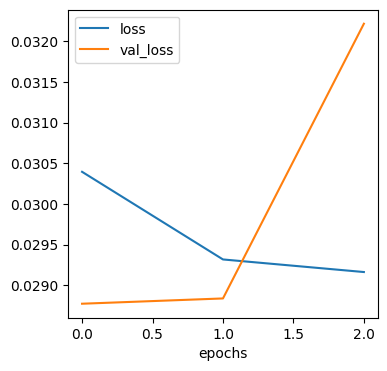

In [25]:
multi_rnn_example_1.multi_models[0].plot_metric(metric="loss", figsize=(4,4))

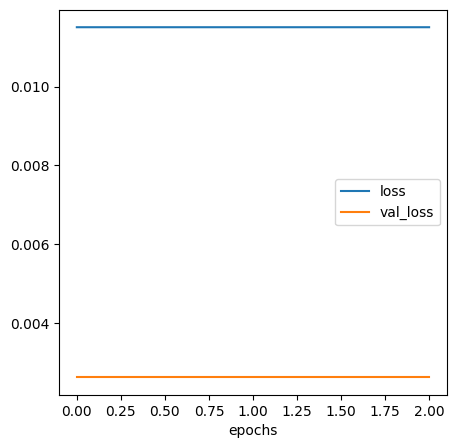

In [26]:
multi_rnn_example_1.multi_models[1].plot_metric(figsize=(5,5))

In [27]:
predictions = multi_rnn_example_1.predict(seq_length) # seq_length = length of test data

1/1 [==============================] - 0s 21ms/step


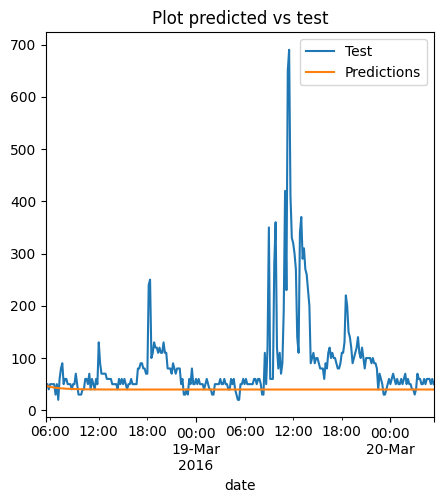

In [28]:
multi_rnn_example_1.multi_models[0].plot_prediction_w_test(predictions)

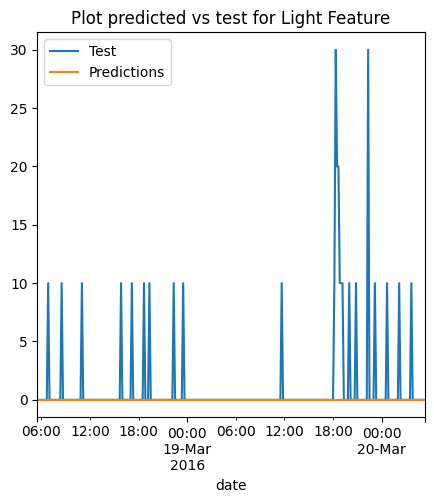

In [29]:
multi_rnn_example_1.multi_models[1].plot_prediction_w_test(predictions, 
                                                           title="Plot predicted vs test for Light Feature")